In [7]:
import pandas as pd
import sys
import os
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from category_encoders import TargetEncoder
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, make_scorer
from sklearn.metrics import confusion_matrix
import optuna
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath("../Sources"))
pd.set_option('display.max_columns', None) 

In [8]:
train = pd.read_csv('..\Datasets\Copy of churn-bigml-80.csv')
test = pd.read_csv('..\Datasets\Copy of churn-bigml-20.csv')

In [9]:
from preprocessing import preprocess_pipeline

In [10]:
X_train, y_train, X_test, y_test = preprocess_pipeline(train, test, model='lightgbm')

In [11]:
f1_scorer = make_scorer(f1_score, average='macro') 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = lgb.LGBMClassifier(random_state=42, verbosity=-1)

scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_scorer)

print("F1 scores on each fold:", scores)
print("Mean F1 score:", scores.mean())

F1 scores on each fold: [0.96489861 0.97034494 0.96704815 0.96705165 0.9692482 ]
Mean F1 score: 0.9677183106939136


In [12]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'num_leaves': trial.suggest_int('num_leaves', 7, 255),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
        'verbosity': -1
    }

    model = lgb.LGBMClassifier(**params)
    
    score = cross_val_score(model, X_train, y_train, scoring=f1_scorer, cv=cv, n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
print(study.best_trial)
print("Best parameters:", study.best_params)

[I 2025-05-18 23:10:00,304] A new study created in memory with name: no-name-c6b6a7f5-7983-4d26-b563-a8e451b7b928
[I 2025-05-18 23:10:04,483] Trial 0 finished with value: 0.9534191244737904 and parameters: {'learning_rate': 0.03900588848781761, 'n_estimators': 811, 'max_depth': 3, 'num_leaves': 247, 'min_child_samples': 83, 'subsample': 0.6505383843638468, 'colsample_bytree': 0.7066285822459333}. Best is trial 0 with value: 0.9534191244737904.
[I 2025-05-18 23:10:07,698] Trial 1 finished with value: 0.882901226315233 and parameters: {'learning_rate': 0.0011065026900367214, 'n_estimators': 162, 'max_depth': 9, 'num_leaves': 186, 'min_child_samples': 71, 'subsample': 0.8099106222611876, 'colsample_bytree': 0.5294560093086726}. Best is trial 0 with value: 0.9534191244737904.
[I 2025-05-18 23:10:11,671] Trial 2 finished with value: 0.9677242017531512 and parameters: {'learning_rate': 0.105669364607538, 'n_estimators': 896, 'max_depth': 4, 'num_leaves': 223, 'min_child_samples': 82, 'subsam

Best trial:
FrozenTrial(number=45, state=1, values=[0.9771678420504099], datetime_start=datetime.datetime(2025, 5, 18, 23, 12, 29, 404518), datetime_complete=datetime.datetime(2025, 5, 18, 23, 12, 33, 763695), params={'learning_rate': 0.09347153289845349, 'n_estimators': 333, 'max_depth': 11, 'num_leaves': 235, 'min_child_samples': 16, 'subsample': 0.6357966369756842, 'colsample_bytree': 0.6169431205391991}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.3, log=True, low=0.001, step=None), 'n_estimators': IntDistribution(high=1000, log=False, low=50, step=1), 'max_depth': IntDistribution(high=15, log=False, low=3, step=1), 'num_leaves': IntDistribution(high=255, log=False, low=7, step=1), 'min_child_samples': IntDistribution(high=100, log=False, low=5, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None)}, trial_id

Classification Report:

              precision    recall  f1-score   support

           0     0.9777    0.9948    0.9861       572
           1     0.9647    0.8632    0.9111        95

    accuracy                         0.9760       667
   macro avg     0.9712    0.9290    0.9486       667
weighted avg     0.9758    0.9760    0.9754       667



<Axes: >

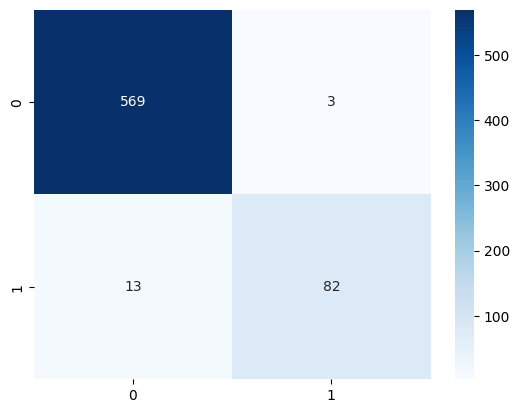

In [13]:
best_model = lgb.LGBMClassifier(**study.best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')

In [14]:
importances = best_model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print(importance_df.head(10))

                   Feature  Importance
30              State_freq        1988
21  avg_intl_call_duration        1739
22           total_minutes        1636
29            Total charge        1592
28        intl_calls_ratio        1572
19   avg_eve_call_duration        1520
5        Total day minutes        1519
8        Total eve minutes        1471
14      Total intl minutes        1433
27             total_calls        1421


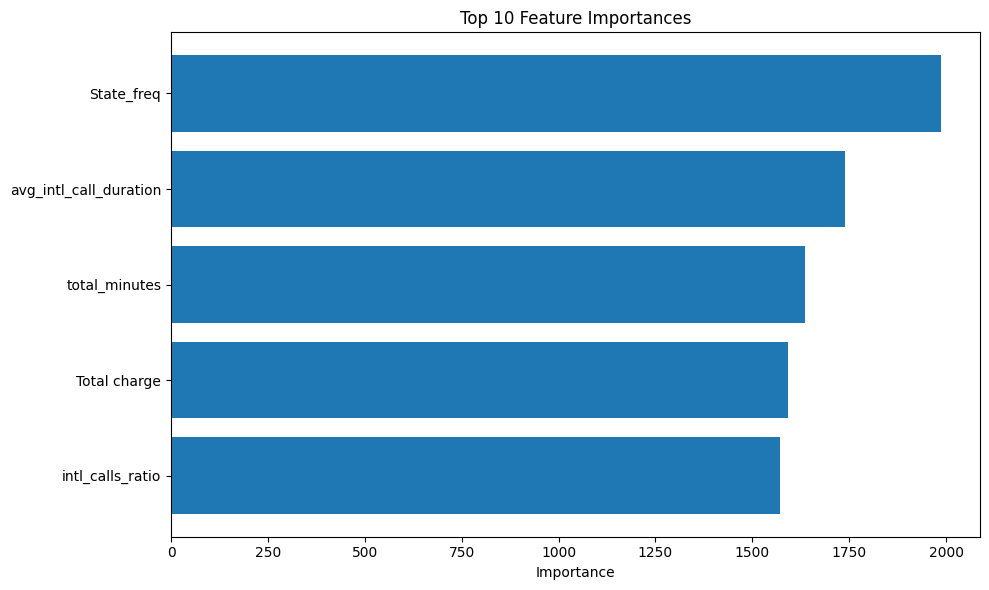

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:5][::-1], importance_df['Importance'][:5][::-1])
plt.xlabel("Importance")
plt.title("Top 5 Feature Importances")
plt.tight_layout()
plt.show()